# Data

In [1]:
# import from google drive
# run this code piece, enter the autorization code
# For mount instructions: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd

from google.colab import drive
drive.mount("/content/drive")

# or import from environment
PROJECT_DIR = "/content/drive/My Drive/Deep Learning System/project"

Mounted at /content/drive


In [2]:
%cd $PROJECT_DIR
# !git clone https://github.com/tuanpham96/bnn-cf-vs-robust "$PROJECT_DIR/bnn-cf-vs-robust"
# %cd bnn-cf-vs-robust
# !git pull

/content/drive/My Drive/Deep Learning System/project


In [3]:
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

import torch
from torchvision import models
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Function
from torch import nn
from torch.utils.data import Dataset

warnings.filterwarnings("ignore")
plt.ion()

In [4]:
date = datetime.now().strftime('%Y-%m-%d')
path = PROJECT_DIR + '/results_pytorch_memory/' + date
if not (os.path.exists(path)):
    os.makedirs(path)

# Natural Corruption

In [ ]:
!pip install wand
!apt-get update && apt install imagemagick

In [10]:
%cd "$PROJECT_DIR//bnn-cf-vs-robust"
%env PYTHONPATH="$PROJECT_DIR/bnn-cf-vs-robust/src"

/content/drive/My Drive/Deep Learning System/project/bnn-cf-vs-robust
env: PYTHONPATH="/content/drive/My Drive/Deep Learning System/project/bnn-cf-vs-robust/src"


In [11]:
# each of the function in here would take a 2D matrix -> 2D matrix, of vals in [0, 1]
from pathlib import Path
from src import rgb_corruptions
rgb_corruptions.corruption_collection

{'brightness': <function src.rgb_corruptions.brightness>,
 'contrast': <function src.rgb_corruptions.contrast>,
 'defocus_blur': <function src.rgb_corruptions.defocus_blur>,
 'elastic_transform': <function src.rgb_corruptions.elastic_transform>,
 'fog': <function src.rgb_corruptions.fog>,
 'frost': <function src.rgb_corruptions.frost>,
 'gaussian_blur': <function src.rgb_corruptions.gaussian_blur>,
 'gaussian_noise': <function src.rgb_corruptions.gaussian_noise>,
 'glass_blur': <function src.rgb_corruptions.glass_blur>,
 'impulse_noise': <function src.rgb_corruptions.impulse_noise>,
 'jpeg_compression': <function src.rgb_corruptions.jpeg_compression>,
 'motion_blur': <function src.rgb_corruptions.motion_blur>,
 'pixelate': <function src.rgb_corruptions.pixelate>,
 'saturate': <function src.rgb_corruptions.saturate>,
 'shot_noise': <function src.rgb_corruptions.shot_noise>,
 'snow': <function src.rgb_corruptions.snow>,
 'spatter': <function src.rgb_corruptions.spatter>,
 'speckle_noise'

In [12]:
# cifar-10
transform_cifar10_train = transforms.Compose(
      [transforms.Resize(220),
        # torchvision.transforms.RandomChoice([torchvision.transforms.RandomRotation(10), torchvision.transforms.RandomCrop((32,32), padding=4, padding_mode = 'edge')]),
        transforms.RandomCrop(200),
        # torchvision.transforms.RandomCrop((32,32), padding=5, padding_mode = 'edge'),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(), 
        # transforms.Lambda(lambda x: apply_corruption(x, fn)),
        transforms.Normalize(mean=(0.0,), std=(1.0,)),       
        ])

cifar10_train_dset = torchvision.datasets.CIFAR10(f'{PROJECT_DIR}/cifar10_pytorch', train=True,
                                                  transform=transform_cifar10_train, download=True)
cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train_dset, batch_size=500, shuffle=False, num_workers=0)


Files already downloaded and verified


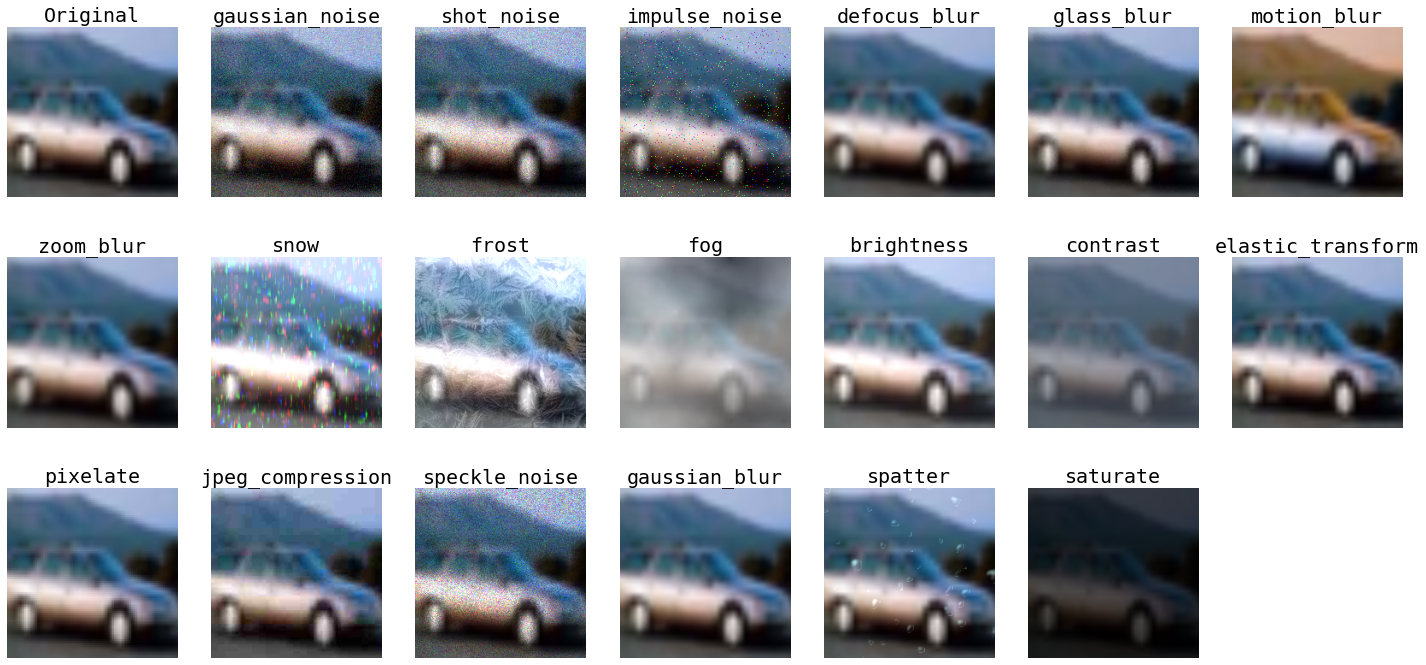

In [18]:
dataiter = iter(cifar10_train_loader)
images, labels = dataiter.next()
image = images[4].numpy().transpose((1, 2, 0))

fns = list(rgb_corruptions.corruption_collection.values())
num_cs = len(fns)
ncols = 7
nrows = int(np.ceil((num_cs+1)/ncols))

plt_ttlfont = {'fontsize' : 20, 'family': 'monospace'}
plt.figure(figsize=(25,12))
plt.subplot(nrows,ncols,1)
plt.imshow(np.squeeze(image), vmin=0, vmax=1, cmap='gray')
plt.title('Original', fontdict=plt_ttlfont)
plt.axis('off')

for i,fn in enumerate(fns):
    c_img = fn(image, severity=1)
    plt.subplot(nrows,ncols,i+2)
    plt.imshow(c_img, vmin=0, vmax=1, cmap='gray')
    plt.title(fn.__name__, fontdict=plt_ttlfont)
    plt.axis('off')

Path(f'{PROJECT_DIR}/figures/cifar10-cifar100').mkdir(parents=True, exist_ok=True)
fig_name = Path(f'{PROJECT_DIR}/figures/cifar10-cifar100') / 'natural-corruption_cifar10.png'
plt.savefig(fig_name)

In [ ]:
def apply_corruption(img, fn):
  x = img.numpy().transpose((1,2,0))
  x = fn(x)
  if x.ndim < 3:
    print('Skipped image.')
    return img
  x = torch.tensor(x.transpose((2,0,1)))
  return x

In [ ]:
# Extracting features of cifar10 with conv layers of resnet pretrained on imagenet
resnet = models.resnet18(pretrained=True)
resnet_conv = nn.Sequential(*list(resnet.children())[:-1])

for param in resnet_conv.parameters():
    param.requires_grad = False

resnet_conv.cuda()

features_train = []
target_train = []
for i in range(10):
    for idx, (data, target) in enumerate(cifar10_train_loader):
        data = data.to('cuda')
        target = target.to('cuda')
        features = resnet_conv(data.float())
        #        print(features.shape)
        features = torch.squeeze(features)
        features_train.append(features)
        target_train.append(target)

features_dset_train = torch.cat(features_train, 0)
target_dset_train = torch.cat(target_train, 0)

Files already downloaded and verified


In [ ]:
for name, fn in rgb_corruptions.corruption_collection.items():
  transform_cifar10_test = transforms.Compose(
    [transforms.Resize(220),
      transforms.CenterCrop(200),
      transforms.ToTensor(),
      transforms.Lambda(lambda x: apply_corruption(x, fn)),
      transforms.Normalize(mean=(0.0,), std=(1.0,))])

  cifar10_test_dset = torchvision.datasets.CIFAR10(f'{PROJECT_DIR}/cifar10_pytorch', train=False,
                                                  transform=transform_cifar10_test, download=True)
  cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_dset, batch_size=500, shuffle=False, num_workers=0)

  
  features_test = []
  target_test = []

  for idx, (data, target) in enumerate(cifar10_test_loader):
      data = data.float().to('cuda')
      target = target.to('cuda')
      features = resnet_conv(data)
      features = torch.squeeze(features)
      features_test.append(features)
      target_test.append(target)

  features_dset_test = torch.cat(features_test, 0)
  target_dset_test = torch.cat(target_test, 0)

  # print(features_dset_train.shape, target_dset_train.shape, features_dset_test.shape, target_dset_test.shape)
  os.mkdir(f'{PROJECT_DIR}/cifar10_features_dataset_{name}')
  # torch.save(features_dset_train, f'{PROJECT_DIR}/cifar10_features_dataset_{name}/train.pt')
  # torch.save(target_dset_train, f'{PROJECT_DIR}/cifar10_features_dataset_{name}/train_targets.pt')
  torch.save(features_dset_test, f'{PROJECT_DIR}/cifar10_features_dataset_{name}/test.pt')
  torch.save(target_dset_test, f'{PROJECT_DIR}/cifar10_features_dataset_{name}/test_targets.pt')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [15]:
# cifar100
transform_cifar100_train = transforms.Compose(
    [transforms.Resize(220),
      # torchvision.transforms.RandomChoice([torchvision.transforms.RandomRotation(10), torchvision.transforms.RandomCrop((32,32), padding=4, padding_mode = 'edge')]),
      transforms.RandomCrop(200),
      # torchvision.transforms.RandomCrop((32,32), padding=5, padding_mode = 'edge'),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.ToTensor(), transforms.Normalize(mean=(0.0,), std=(1.0,))])

cifar100_train_dset = torchvision.datasets.CIFAR100(f'{PROJECT_DIR}/cifar100_pytorch', train=True,
                                                    transform=transform_cifar100_train, download=True)
cifar100_train_loader = torch.utils.data.DataLoader(cifar100_train_dset, batch_size=500, shuffle=False,
                                                    num_workers=0)

Files already downloaded and verified


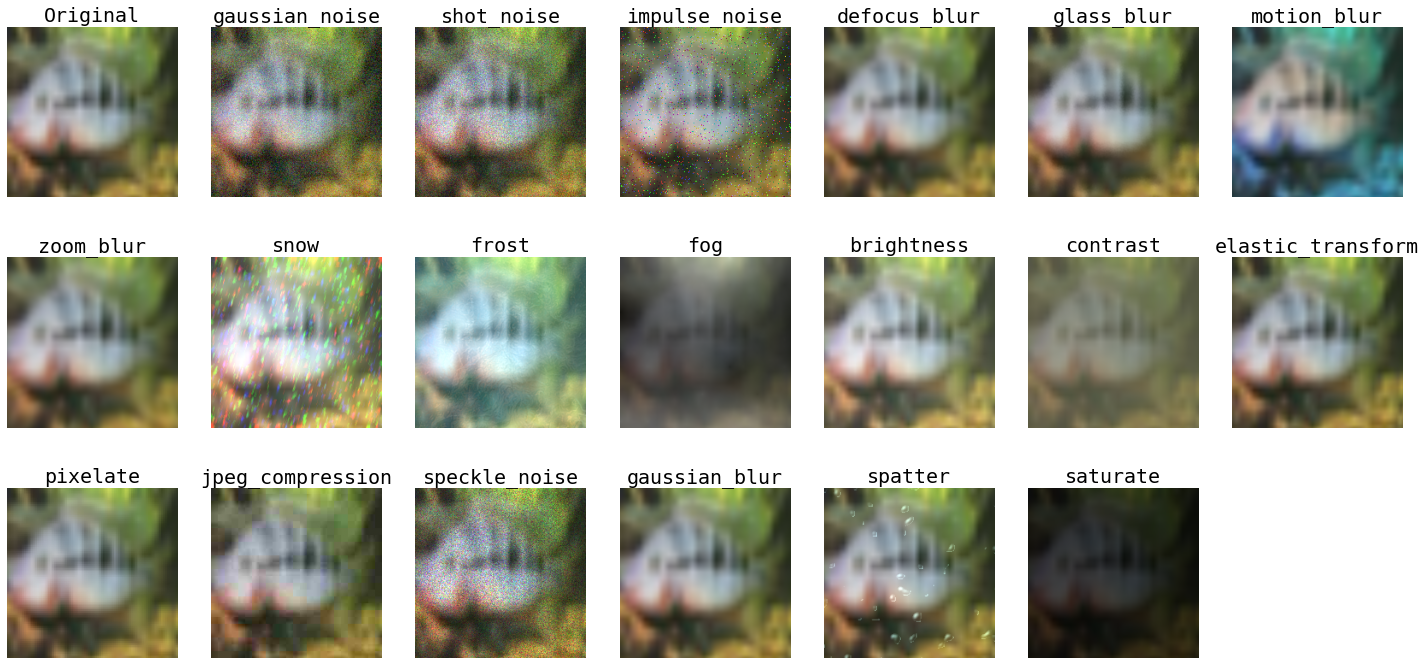

In [17]:
dataiter = iter(cifar100_train_loader)
images, labels = dataiter.next()
image = images[4].numpy().transpose((1, 2, 0))

fns = list(rgb_corruptions.corruption_collection.values())
num_cs = len(fns)
ncols = 7
nrows = int(np.ceil((num_cs+1)/ncols))

plt_ttlfont = {'fontsize' : 20, 'family': 'monospace'}
plt.figure(figsize=(25,12))
plt.subplot(nrows,ncols,1)
plt.imshow(np.squeeze(image), vmin=0, vmax=1, cmap='gray')
plt.title('Original', fontdict=plt_ttlfont)
plt.axis('off')

for i,fn in enumerate(fns):
    c_img = fn(image, severity=1)
    plt.subplot(nrows,ncols,i+2)
    plt.imshow(c_img, vmin=0, vmax=1, cmap='gray')
    plt.title(fn.__name__, fontdict=plt_ttlfont)
    plt.axis('off')

Path(f'{PROJECT_DIR}/figures/cifar10-cifar100').mkdir(parents=True, exist_ok=True)
fig_name = Path(f'{PROJECT_DIR}/figures/cifar10-cifar100') / 'natural-corruption_cifar100.png'
plt.savefig(fig_name)

In [ ]:
# Extracting features of cifar10 with conv layers of resnet pretrained on imagenet
resnet = models.resnet18(pretrained=True)
resnet_conv = nn.Sequential(*list(resnet.children())[:-1])

for param in resnet_conv.parameters():
    param.requires_grad = False

resnet_conv.cuda()

features_train = []
target_train = []
for i in range(10):
    for idx, (data, target) in enumerate(cifar100_train_loader):
        data = data.to('cuda')
        target = target.to('cuda')
        features = resnet_conv(data.float())
        #        print(features.shape)
        features = torch.squeeze(features)
        features_train.append(features)
        target_train.append(target)

features_dset_train = torch.cat(features_train, 0)
target_dset_train = torch.cat(target_train, 0)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
for name, fn in rgb_corruptions.corruption_collection.items():
  transform_cifar100_test = transforms.Compose(
    [transforms.Resize(220),
      transforms.CenterCrop(200),
      transforms.ToTensor(),
      transforms.Lambda(lambda x: apply_corruption(x, fn)),
      transforms.Normalize(mean=(0.0,), std=(1.0,))])

  cifar100_test_dset = torchvision.datasets.CIFAR100(f'{PROJECT_DIR}/cifar100_pytorch', train=False,
                                                  transform=transform_cifar100_test, download=True)
  cifar100_test_loader = torch.utils.data.DataLoader(cifar100_test_dset, batch_size=500, shuffle=False, num_workers=0)

  
  features_test = []
  target_test = []

  for idx, (data, target) in enumerate(cifar100_test_loader):
      data = data.float().to('cuda')
      target = target.to('cuda')
      features = resnet_conv(data)
      features = torch.squeeze(features)
      features_test.append(features)
      target_test.append(target)

  features_dset_test = torch.cat(features_test, 0)
  target_dset_test = torch.cat(target_test, 0)

  # os.mkdir(f'{PROJECT_DIR}/cifar100_features_dataset_{name}')
  torch.save(features_dset_test, f'{PROJECT_DIR}/cifar100_features_dataset_{name}/test.pt')
  torch.save(target_dset_test, f'{PROJECT_DIR}/cifar100_features_dataset_{name}/test_targets.pt')

## Run BNN 

In [ ]:
%cd "$PROJECT_DIR"
%env PYTHONPATH="$PROJECT_DIR/bnn-cf-vs-robust/src"
# !echo $PYTHONPATH

!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_gaussian_noise' 'animals_gaussian_noise'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_gaussian_noise' 'animals_gaussian_noise'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_gaussian_noise' 'animals_gaussian_noise'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_shot_noise' 'animals_shot_noise'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_shot_noise' 'animals_shot_noise'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_shot_noise' 'animals_shot_noise'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_impulse_noise' 'animals_impulse_noise'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_impulse_noise' 'animals_impulse_noise'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_impulse_noise' 'animals_impulse_noise'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_defocus_blur' 'animals_defocus_blur'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_defocus_blur' 'animals_defocus_blur'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_defocus_blur' 'animals_defocus_blur'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_glass_blur' 'animals_glass_blur'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_glass_blur' 'animals_glass_blur'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_glass_blur' 'animals_glass_blur'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_motion_blur' 'animals_motion_blur'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_motion_blur' 'animals_motion_blur'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_motion_blur' 'animals_motion_blur'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_zoom_blur' 'animals_zoom_blur'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_zoom_blur' 'animals_zoom_blur'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_zoom_blur' 'animals_zoom_blur'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_snow' 'animals_snow'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_snow' 'animals_snow'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_snow' 'animals_snow'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_frost' 'animals_frost'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_frost' 'animals_frost'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_frost' 'animals_frost'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_fog' 'animals_fog'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_fog' 'animals_fog'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_fog' 'animals_fog'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_brightness' 'animals_brightness'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_brightness' 'animals_brightness'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_brightness' 'animals_brightness'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_contrast' 'animals_contrast'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_contrast' 'animals_contrast'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_contrast' 'animals_contrast'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_elastic_transform' 'animals_elastic_transform'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_elastic_transform' 'animals_elastic_transform'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_elastic_transform' 'animals_elastic_transform'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_pixelate' 'animals_pixelate'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_pixelate' 'animals_pixelate'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_pixelate' 'animals_pixelate'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_jpeg_compression' 'animals_jpeg_compression'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_jpeg_compression' 'animals_jpeg_compression'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_jpeg_compression' 'animals_jpeg_compression'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_speckle_noise' 'animals_speckle_noise'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_speckle_noise' 'animals_speckle_noise'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_speckle_noise' 'animals_speckle_noise'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_gaussian_blur' 'animals_gaussian_blur'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_gaussian_blur' 'animals_gaussian_blur'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_gaussian_blur' 'animals_gaussian_blur'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_spatter' 'animals_spatter'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_spatter' 'animals_spatter'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_spatter' 'animals_spatter'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 0.0 --epochs-per-task 10 --task-sequence 'vehicles_saturate' 'animals_saturate'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.0 --epochs-per-task 10 --task-sequence 'vehicles_saturate' 'animals_saturate'
!python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'bn' --decay 1e-8 --in-size 512 --hidden-layers 2048 --out-size 10 --lr 0.005 --meta 1.3 --epochs-per-task 10 --task-sequence 'vehicles_saturate' 'animals_saturate'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_gaussian_noise-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_gaussian_noise-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_gaussian_noise-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_shot_noise-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_shot_noise-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_shot_noise-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_impulse_noise-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_impulse_noise-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_impulse_noise-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_defocus_blur-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_defocus_blur-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_defocus_blur-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_glass_blur-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_glass_blur-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_glass_blur-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_motion_blur-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_motion_blur-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_motion_blur-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_zoom_blur-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_zoom_blur-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_zoom_blur-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_snow-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_snow-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_snow-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_frost-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_frost-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_frost-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_fog-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_fog-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_fog-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_brightness-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_brightness-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_brightness-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_contrast-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_contrast-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_contrast-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_elastic_transform-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_elastic_transform-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_elastic_transform-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_pixelate-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_pixelate-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_pixelate-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_jpeg_compression-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_jpeg_compression-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_jpeg_compression-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_speckle_noise-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_speckle_noise-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_speckle_noise-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_gaussian_blur-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_gaussian_blur-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_gaussian_blur-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_spatter-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_spatter-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_spatter-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 0.0 --epochs-per-task 3 --task-sequence 'cifar100_saturate-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.0 --epochs-per-task 3 --task-sequence 'cifar100_saturate-6'
# !python bnn-cf-vs-robust/src/bnn_main.py --net 'bnn' --norm 'in' --scenario 'domain' --in-size 512 --hidden-layers 2048 2048 --out-size 100 --lr 0.005 --meta 1.3 --epochs-per-task 3 --task-sequence 'cifar100_saturate-6'


/content/drive/My Drive/Deep Learning System/project
env: PYTHONPATH="/content/drive/My Drive/Deep Learning System/project/bnn-cf-vs-robust/src"
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
BNN(
  (layers): ModuleDict(
    (fc1): BinarizeLinear(in_features=512, out_features=2048, bias=False)
    (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): BinarizeLinear(in_features=2048, out_features=10, bias=False)
    (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
/content/drive/My Drive/Deep Lear

# Plots

In [ ]:
!pip install plotly==5.4.0
!pip install -U kaleido
!pip install path
!pip install --upgrade --user matplotlib 

In [ ]:
import os, glob 
import pandas as pd 
import numpy as np 
import yaml 
from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go

In [ ]:
%cd $PROJECT_DIR
data_root = Path('results/2021-11-30/')
fig_root = Path('figures')
fig_root.mkdir(exist_ok=True, parents=True)

/content/drive/My Drive/Deep Learning System/project


In [ ]:
def load_df(data_root, data_dir, prm_fns = None):
    data_path = data_root / data_dir
    csv_file = glob.glob(str(data_path / '*.csv'))[0]
    prm_file = data_path / 'hyperparameters.txt'
  
    hyp_params = yaml.safe_load(open(prm_file))
    hyp_params = {k:v for list_item in hyp_params for (k,v) in list_item.items()}
    corruption = hyp_params['task sequence'][0].split('_', maxsplit=1)[1]

    prm2save = {k: fn(hyp_params) for k, fn in prm_fns.items()} if prm_fns else dict()

    df = pd.read_csv(csv_file)\
            .filter(regex='(acc_test_.*|task_order|epoch)', axis=1)\
            .assign(**prm2save)\
            .melt(id_vars=['task_order','epoch'] + list(prm2save.keys()), 
                var_name='test_set', value_name='test_acc')
            
    df['test_set'] = df['test_set'].apply(lambda x: 'task-' + x[-1])
    df['corruption'] = corruption

    max_epoch = max(df.epoch)
    df.epoch = (df.task_order - 1) * (max_epoch) + df.epoch 
    return df

def load_dfs(data_root, prm_fns=None, concat=True):
    df = [load_df(data_root, d, prm_fns) 
          for d in os.listdir(data_root) if d[-3:] != 'png' 
          # and d not in ['01-38-30_gpu0', '00-03-32_gpu0', '00-11-51_gpu0', '01-04-46_gpu0', 
          #                                                                 '01-10-44_gpu0', '01-16-45_gpu0', '01-22-44_gpu0', '01-30-39_gpu0']
          ]
    if concat:
        df = pd.concat(df, ignore_index=True)
    return df

In [ ]:
prm_fns = {
    'meta': lambda hyp_prm: hyp_prm['meta'][0],
    'num_hidden': lambda hyp_prm: hyp_prm['hidden layers'][0]
}

df = load_dfs(data_root, prm_fns)
df = df.loc[df['epoch'] == 18]
df['test_set'] = df['test_set'].apply(lambda x: x.split('-')[1])
df['corruption'] = df['corruption'].apply(lambda x: x.split('-')[0])
df = df.sort_values(by=['meta', 'test_set'])

In [ ]:
axis_config = dict(
    showline=True,
    showgrid=False,
    showticklabels=True,
    linecolor='rgb(0, 0, 0)',
    linewidth=2,    
    ticks='outside',
    tickwidth=2
    )

font_config = dict(
    family="Fira Sans",
    size=15,
    color='black'
    )

title_config = dict(
    title_x = 0.5,
    title_y = 0.95,
    title_xanchor = 'center',
    title_yanchor = 'top',
    title_font_size=20
)

general_layout = go.Layout(
    xaxis=axis_config,
    yaxis=axis_config,
    font=font_config,
    margin=dict(autoexpand=True,l=100,r=50,t=100,b=120),
    showlegend=True,
    plot_bgcolor='white',
    autosize=True,
    **title_config
)

for i in range(1,10): # for subplots
    general_layout['xaxis' + str(i)] = axis_config
    general_layout['yaxis' + str(i)] = axis_config

In [ ]:
fig = px.line(
    df, x="test_set", y="test_acc", 
    color="meta",
    facet_col="corruption",
    color_discrete_sequence=px.colors.sequential.Burg,
    facet_col_wrap=7, 
    facet_col_spacing=0.03,
    facet_row_spacing=0.12,
    markers = True
    )

fig.update_traces(line=dict(width=3), marker=dict(size=15))

for i in range(1,30): # for subplots - u can do as many as u want
    general_layout['xaxis' + str(i)] = axis_config
    general_layout['yaxis' + str(i)] = axis_config

fig.update_layout(
    general_layout,
    width=1700,
    title_y = 0.97,
    height=800,
    font_size = 18, title_font_size = 27,
    # title_text='CIFAR-10 features',
    font_family="Calibri",
    legend=dict(
        yanchor="top",
        y=0.10,
        xanchor="right",
        x=0.90
    ),
  #   xaxis = dict(
  #     tickmode = 'linear',
  #     tick0 = 0,
  #     dtick = 2
  # )
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_yaxes(showticklabels=True)
fig.write_image(fig_root / 'corruption_cifar10.png')

fig.show()